# Data Collection

In [1]:
import pandas as pd
import numpy as np
#turning the CSV dataset into a dataframe
df = pd.read_csv('USD_RUB Historical Data (2).csv')
usddata = df
usddata.columns = ['date','USD_Price','USD_Open','USD_High','USD_Low','Change %']
usddata.describe()

,USD_Price,USD_Open,USD_High,USD_Low
count,4774.000000,4774.000000,4774.000000,4774.000000
mean,44.313425,44.296398,44.579770,44.034909
std,19.020701,18.991476,19.290728,18.751049
min,23.156000,23.157000,23.203000,23.052000
25%,28.670000,28.667250,28.720500,28.614550
50%,32.374500,32.347500,32.442500,32.128000
75%,63.713600,63.708625,63.982650,63.379850
max,143.000000,129.000000,158.300000,125.500000


In [2]:
#turning the CSV dataset into a dataframe
##renaming the columns since previously long column name caused errors
header_list = ["Day", "OilPrice"]
df1 = pd.read_csv('Cushing_OK_WTI_Spot_Price_FOB (2).csv',skiprows=5,names =header_list )
#indeces should be reversed 
df1 = df1[::-1] 
WTIdata = df1
WTIdata.describe()
# print("df1min is:",df1.min())
WTIdata

,Day,OilPrice
9169,01/2/1986,25.56
9168,01/3/1986,26.00
9167,01/6/1986,26.53
9166,01/7/1986,25.85
9165,01/8/1986,25.87
...,...,...
4,05/17/2022,112.31
3,05/18/2022,109.67
2,05/19/2022,112.21
1,05/20/2022,112.63


In [3]:
df = pd.read_csv('EUR_RUB Historical Data.csv')
eurdata = df
eurdata.columns = ['date','EUR_Price','EUR_Open','EUR_High','EUR_Low','Change %']
eurdata.describe()

,EUR_Price,EUR_Open,EUR_High,EUR_Low
count,4796.000000,4796.000000,4796.000000,4796.000000
mean,53.879060,53.836743,54.204712,53.549477
std,19.171629,19.221707,19.458707,18.934326
min,33.267000,33.240000,33.464000,33.212000
25%,36.869500,36.855750,36.980500,36.715000
50%,43.783500,43.751500,43.967500,43.586500
75%,71.391500,71.357750,71.767500,70.998000
max,127.000000,144.791000,144.791000,121.655000


In [4]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Create an URL object
url = 'https://www.cbr.ru/eng/hd_base/overnight/?UniDbQuery.Posted=True&UniDbQuery.From=18.06.1998&UniDbQuery.To=04.05.2022'
# Create object page
page = requests.get(url)

# parser-lxml = Change html to Python friendly format
# Obtain page's information
soup = BeautifulSoup(page.text, 'lxml')
soup

# Obtain information from tag <table>
table1 = soup.find(class_ ="data")
table1

# Obtain every title of columns with tag <th>
headers = []
for i in table1.find_all('th'):
    title = i.text
    headers.append(title)
    
# Create a dataframe
mydata = pd.DataFrame(columns = headers)

# Create a for loop to fill mydata
for j in table1.find_all('tr')[1:]:
    row_data = j.find_all('td')
    row = [i.text for i in row_data]
    length = len(mydata)
    mydata.loc[length] = row

#save into a csv file
mydata.to_csv('Interest_rate.csv')
df = pd.read_csv('Interest_rate.csv',index_col=0)
overnightint = df
overnightint.columns = ['date','Overnight_int_rate']
overnightint.describe()

In [5]:
df = pd.read_csv('Interest_rate.csv',index_col=0)
overnightint = df
overnightint.columns = ['date','Overnight_int_rate']
overnightint.describe()

,Overnight_int_rate
count,111.000000
mean,30.734234
std,39.732033
min,5.250000
25%,8.500000
50%,11.500000
75%,40.000000
max,250.000000


# Data Cleaning

In [6]:
#mismatch of numbers indicate skipped dates in the WTI dataset
#this should be considered during the merge of the two datasets
#Date formats in two datasets are different and should be uniformized
from dateutil.parser import parse
def calend(string):
    return parse(string)

WTIdata['Calendar_date'] = WTIdata['Day'].apply(calend)
WTIdata = WTIdata.drop(['Day'],axis=1)

usddata['Calendar_date'] = usddata['date'].apply(calend)
usddata = usddata.drop(['date'],axis=1)

eurdata['Calendar_date'] = eurdata['date'].apply(calend)
eurdata = eurdata.drop(['date'],axis=1)


In [7]:
#creating a dataframe with dates in the selected time period that contains only business days 
date = pd.DataFrame()
date['Calendar_date'] = pd.date_range(start='12/1/2003', end='5/23/2022',freq='B')
date

,Calendar_date
0,2003-12-01
1,2003-12-02
2,2003-12-03
3,2003-12-04
4,2003-12-05
...,...
4816,2022-05-17
4817,2022-05-18
4818,2022-05-19
4819,2022-05-20


In [8]:
#merging businessday data frame with ruble data frame
all_curr_wti =  pd.merge(date,usddata, on="Calendar_date",how='left')
all_curr_wti =  pd.merge(all_curr_wti,eurdata, on="Calendar_date",how='left')
all_curr_wti = pd.merge(all_curr_wti,WTIdata, on="Calendar_date",how='left')

In [9]:
#checking any missing values (null or NaN)
is_NaN = all_curr_wti[all_curr_wti.isnull().any(axis=1)]
is_NaN

,Calendar_date,USD_Price,USD_Open,USD_High,USD_Low,Change %_x,EUR_Price,EUR_Open,EUR_High,EUR_Low,Change %_y,OilPrice
18,2003-12-25,29.2420,29.2380,29.2500,29.1840,-0.00%,36.406,36.392,36.449,36.326,-0.03%,NaN
19,2003-12-26,29.3560,29.2300,29.3760,29.2250,0.39%,36.488,36.397,36.605,36.359,0.23%,NaN
23,2004-01-01,NaN,NaN,NaN,NaN,NaN,36.655,36.806,36.845,36.453,-0.41%,NaN
24,2004-01-02,29.2400,29.2300,29.2400,29.2300,-0.01%,36.797,36.657,36.937,36.599,0.39%,NaN
35,2004-01-19,28.7910,28.7820,28.8100,28.7700,0.01%,35.574,35.576,35.772,35.496,-0.24%,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4730,2022-01-17,76.1055,76.2202,76.7754,75.6964,-0.15%,86.835,87.005,87.758,86.257,-0.20%,NaN
4755,2022-02-21,80.0170,77.9465,80.3438,76.1358,3.47%,90.230,87.544,90.723,86.607,3.07%,NaN
4794,2022-04-15,79.9950,80.8975,80.8991,79.2471,-1.12%,87.283,89.417,90.268,86.862,-2.39%,NaN
4805,2022-05-02,NaN,NaN,NaN,NaN,NaN,74.197,77.282,77.407,73.513,-4.06%,105.18


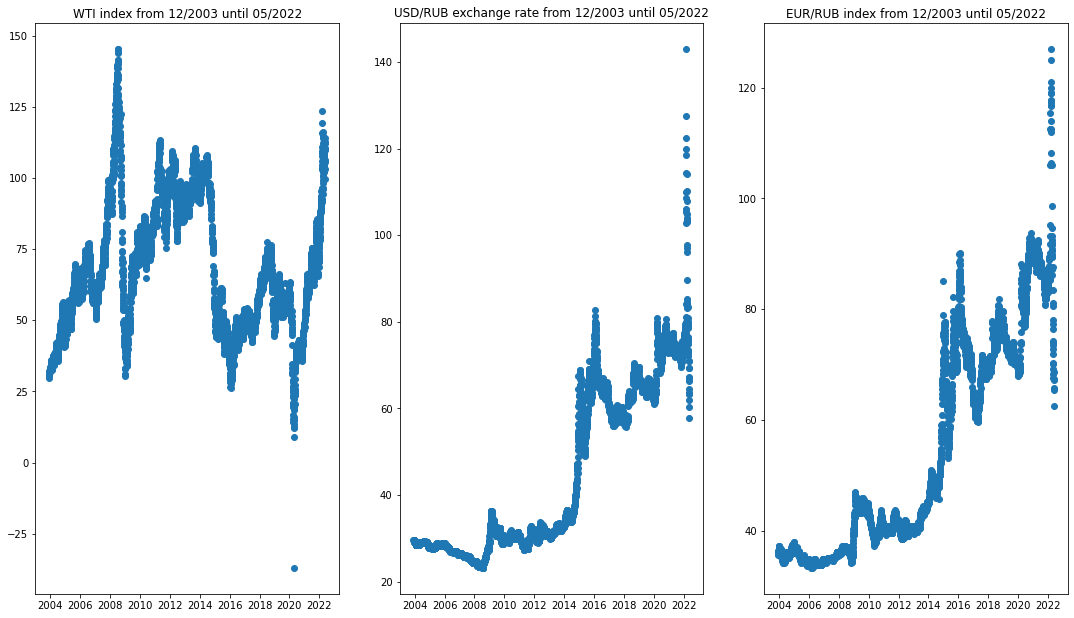

In [10]:
#scatter plot of each feature (variables in the dataframe will help understanding general patterns and outliers)
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)

ax1 = fig.add_subplot(131) 
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('WTI index from 12/2003 until 05/2022')
ax2.set_title('USD/RUB exchange rate from 12/2003 until 05/2022')
ax3.set_title('EUR/RUB index from 12/2003 until 05/2022')

ax1.scatter(all_curr_wti['Calendar_date'],all_curr_wti['OilPrice'])
ax2.scatter(all_curr_wti['Calendar_date'],all_curr_wti['USD_Price'])
ax3.scatter(all_curr_wti['Calendar_date'],all_curr_wti['EUR_Price'])
plt.show()

In [11]:
#an outlier on 2016 with a value close to 0 is identified from the scatterplot
#the day of the outlier values was found 
min_value = all_curr_wti['OilPrice'].min()
print (all_curr_wti['OilPrice'].iloc[all_curr_wti.index[all_curr_wti.OilPrice == min_value]])

4275   -36.98
Name: OilPrice, dtype: float64


In [12]:
all_curr_wti['Change %_x'] = all_curr_wti['Change %_x'].str.replace('%','').astype(float)
all_curr_wti['Change %_y'] = all_curr_wti['Change %_y'].str.replace('%','').astype(float)

In [13]:
#there are 313 missing data points in the data frame
#NaN datapoints are replaced by interpolating the average of the closes three datapoints
a = all_curr_wti.rolling(3).mean()
b = all_curr_wti.iloc[::-1].rolling(3).mean()
c = a.fillna(b).fillna(all_curr_wti).interpolate(method='nearest').ffill().bfill()
all_curr_wti = all_curr_wti.fillna(c)
all_curr_wti

,Calendar_date,USD_Price,USD_Open,USD_High,USD_Low,Change %_x,EUR_Price,EUR_Open,EUR_High,EUR_Low,Change %_y,OilPrice
0,2003-12-01,29.7020,29.7350,29.7410,29.6900,-0.13,35.530,35.604,35.810,35.439,-0.38,29.89
1,2003-12-02,29.7000,29.6960,29.7100,29.6900,-0.01,35.884,35.553,35.919,35.456,1.00,30.74
2,2003-12-03,29.6950,29.6930,29.7000,29.6890,-0.02,35.944,35.866,36.024,35.810,0.17,30.61
3,2003-12-04,29.6920,29.6910,29.7010,29.6850,-0.01,35.883,35.946,36.100,35.702,-0.17,31.24
4,2003-12-05,29.6310,29.6830,29.6910,29.6230,-0.21,36.046,35.865,36.090,35.734,0.45,30.68
...,...,...,...,...,...,...,...,...,...,...,...,...
4816,2022-05-17,63.6000,63.4000,63.9696,63.1746,0.32,68.569,67.469,69.598,65.985,1.64,112.31
4817,2022-05-18,63.4450,63.6000,64.0300,63.0010,-0.24,67.289,68.566,69.359,65.413,-1.87,109.67
4818,2022-05-19,61.9050,63.4450,63.6000,61.5747,-2.43,65.728,67.286,68.310,64.907,-2.32,112.21
4819,2022-05-20,60.2325,61.9050,61.9050,57.1250,-2.70,65.485,65.728,67.441,61.256,-0.37,112.63


In [14]:
#double checking whether the NaN values have been replaced 
is_NaN = all_curr_wti[all_curr_wti.isnull().any(axis=1)]
is_NaN

,Calendar_date,USD_Price,USD_Open,USD_High,USD_Low,Change %_x,EUR_Price,EUR_Open,EUR_High,EUR_Low,Change %_y,OilPrice


In [15]:
import pandas as pd
#turning the CSV dataset into a dataframe
df = pd.read_csv('russia.inflation.monthly (statbureau.org).csv')
Inflate = df
#Dropping the total column
Inflate = Inflate.iloc[:, :-1]


#Using melt function to stack up the columns and rows 
infaltion_rate = pd.melt(Inflate, id_vars=['Year'], var_name=['Month'])
#Tranversing the data month in words to date-time
infaltion_rate['Date'] = pd.to_datetime(infaltion_rate['Year'].astype(str) + '-' + infaltion_rate['Month'].astype(str)).dt.strftime('%Y-%m')
#Dropping the exessive columns and reset the index
infaltion_rate = infaltion_rate.sort_values(by=['Date']).drop(columns=['Month', 'Year']).reset_index(drop=['index'])
#Reindexing in wanted format 
infaltion_rate = infaltion_rate.reindex(['Date','value'], axis=1)
#Dropping the last 8 NaN values 
infaltion_rate = infaltion_rate.iloc[:-7, :]


In [16]:
print(infaltion_rate.loc[infaltion_rate['Date'] == '2003-12'])

        Date  value
155  2003-12    1.1


In [17]:
#select only data from 12-2003
infaltion_rate = infaltion_rate[155:]
#rename date column to Calendar_date
#infaltion_rate.columns = ['Calendar_date','inflation_rate']

In [18]:
#data frame should be reversed so that index 0 corresponds to the earliest date
overnightint = overnightint[::-1]

#date format should be changed 
from dateutil.parser import parse
def calend(string):
    return parse(string)

overnightint['Calendar_date'] = overnightint['date'].apply(calend)
overnightint = overnightint.drop(['date'],axis=1)
date = pd.DataFrame()
date['Calendar_date'] = pd.date_range(start='6/18/1998', end='5/23/2022',freq='B')
overnight_rate = pd.merge(date,overnightint,on = 'Calendar_date', how = 'left' )
overnight_rate= overnight_rate.fillna(method='ffill')
overnight_rate

,Calendar_date,Overnight_int_rate
0,1998-06-18,78.0
1,1998-06-19,60.0
2,1998-06-22,60.0
3,1998-06-23,60.0
4,1998-06-24,60.0
...,...,...
6238,2022-05-17,15.0
6239,2022-05-18,15.0
6240,2022-05-19,15.0
6241,2022-05-20,15.0


In [19]:
print(overnight_rate.loc[overnight_rate['Calendar_date'] == '2003-12-1'])
print(overnight_rate.loc[overnight_rate['Calendar_date'] == '2022-5-23'])

     Calendar_date  Overnight_int_rate
1422    2003-12-01                20.0
     Calendar_date  Overnight_int_rate
6242    2022-05-23                15.0


In [20]:
overnight_rate = overnight_rate[1422:6243]
overnight_rate['MonthYear'] = overnight_rate['Calendar_date'].dt.to_period('M')
#creating a separate data frame with monthly values 
overnight_rate = overnight_rate.groupby(overnight_rate['MonthYear']).mean().reset_index()
overnight_rate.columns = ['Calendar_date','Overnight_int_rate']

/var/folders/hh/b9jhpyvd09x3thlbfkdlhz1c0000gn/T/ipykernel_1961/731212201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overnight_rate['MonthYear'] = overnight_rate['Calendar_date'].dt.to_period('M')


In [21]:
#creating a column with only year and month values 
all_curr_wti['MonthYear'] = all_curr_wti['Calendar_date'].dt.to_period('M')
#creating a separate data frame with monthly values 
all_curr_wti = all_curr_wti.groupby(all_curr_wti['MonthYear']).mean().reset_index()
all_curr_wti

,MonthYear,USD_Price,USD_Open,USD_High,USD_Low,Change %_x,EUR_Price,EUR_Open,EUR_High,EUR_Low,Change %_y,OilPrice
0,2003-12,29.413304,29.428435,29.451174,29.381913,-0.073913,36.210087,36.133957,36.326087,35.993348,0.138261,32.157826
1,2004-01,28.844485,28.873500,28.895258,28.819167,-0.116364,36.344273,36.386409,36.605682,36.130045,-0.150455,34.210758
2,2004-02,28.506100,28.500100,28.544400,28.473200,-0.001500,36.018200,35.990750,36.256350,35.789250,0.010500,34.658333
3,2004-03,28.532304,28.530609,28.556174,28.505739,-0.000870,34.994696,35.007391,35.230739,34.767000,-0.060870,36.741304
4,2004-04,28.718864,28.693727,28.744727,28.672182,0.079091,34.456409,34.453045,34.634636,34.232364,-0.044091,36.723636
...,...,...,...,...,...,...,...,...,...,...,...,...
217,2022-01,76.617710,76.487933,77.184152,75.935757,0.175714,86.711238,86.594429,87.404667,85.948476,0.142381,83.200317
218,2022-02,79.942150,78.708405,81.262335,77.132105,1.726000,88.795900,87.858600,90.404350,87.041700,1.044500,91.673500
219,2022-03,106.447391,105.951957,111.294535,101.504461,-0.884348,113.299435,115.651522,120.643522,108.037174,-0.589130,108.502609
220,2022-04,77.603810,78.186667,78.893571,76.419238,-0.735238,86.671095,87.614952,89.549238,83.795476,-0.715238,101.877302


In [22]:
all_curr_wti.columns = ['Calendar_date','USD_Price','USD_Open','USD_High','USD_Low','Change %_x','EUR_Price','EUR_Open','EUR_High','EUR_Low','Change %_y','OilPrice'] 
all_curr_wti =  pd.merge(all_curr_wti,overnight_rate, on="Calendar_date",how='left')
all_curr_wti

,Calendar_date,USD_Price,USD_Open,USD_High,USD_Low,Change %_x,EUR_Price,EUR_Open,EUR_High,EUR_Low,Change %_y,OilPrice,Overnight_int_rate
0,2003-12,29.413304,29.428435,29.451174,29.381913,-0.073913,36.210087,36.133957,36.326087,35.993348,0.138261,32.157826,20.000000
1,2004-01,28.844485,28.873500,28.895258,28.819167,-0.116364,36.344273,36.386409,36.605682,36.130045,-0.150455,34.210758,16.727273
2,2004-02,28.506100,28.500100,28.544400,28.473200,-0.001500,36.018200,35.990750,36.256350,35.789250,0.010500,34.658333,14.000000
3,2004-03,28.532304,28.530609,28.556174,28.505739,-0.000870,34.994696,35.007391,35.230739,34.767000,-0.060870,36.741304,14.000000
4,2004-04,28.718864,28.693727,28.744727,28.672182,0.079091,34.456409,34.453045,34.634636,34.232364,-0.044091,36.723636,14.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,2022-01,76.617710,76.487933,77.184152,75.935757,0.175714,86.711238,86.594429,87.404667,85.948476,0.142381,83.200317,9.500000
218,2022-02,79.942150,78.708405,81.262335,77.132105,1.726000,88.795900,87.858600,90.404350,87.041700,1.044500,91.673500,10.575000
219,2022-03,106.447391,105.951957,111.294535,101.504461,-0.884348,113.299435,115.651522,120.643522,108.037174,-0.589130,108.502609,21.000000
220,2022-04,77.603810,78.186667,78.893571,76.419238,-0.735238,86.671095,87.614952,89.549238,83.795476,-0.715238,101.877302,15.571429


In [23]:
infaltion_rate

,Date,value
155,2003-12,1.10
156,2004-01,1.75
157,2004-02,0.99
158,2004-03,0.75
159,2004-04,0.99
...,...,...
372,2022-01,0.99
373,2022-02,1.17
374,2022-03,7.61
375,2022-04,1.56


In [24]:
infaltion_rate = infaltion_rate.reset_index()
infaltion_rate = infaltion_rate.drop(columns=['index'])
infaltion_rate['Date']= pd.to_datetime(infaltion_rate['Date'])
infaltion_rate['Date']=infaltion_rate['Date'].dt.to_period("M")
infaltion_rate.columns = ['Calendar_date','Inflation_rate']
infaltion_rate

,Calendar_date,Inflation_rate
0,2003-12,1.10
1,2004-01,1.75
2,2004-02,0.99
3,2004-03,0.75
4,2004-04,0.99
...,...,...
217,2022-01,0.99
218,2022-02,1.17
219,2022-03,7.61
220,2022-04,1.56


In [25]:
all_curr_wti =  pd.merge(all_curr_wti,infaltion_rate, on="Calendar_date",how='left')
all_curr_wti

,Calendar_date,USD_Price,USD_Open,USD_High,USD_Low,Change %_x,EUR_Price,EUR_Open,EUR_High,EUR_Low,Change %_y,OilPrice,Overnight_int_rate,Inflation_rate
0,2003-12,29.413304,29.428435,29.451174,29.381913,-0.073913,36.210087,36.133957,36.326087,35.993348,0.138261,32.157826,20.000000,1.10
1,2004-01,28.844485,28.873500,28.895258,28.819167,-0.116364,36.344273,36.386409,36.605682,36.130045,-0.150455,34.210758,16.727273,1.75
2,2004-02,28.506100,28.500100,28.544400,28.473200,-0.001500,36.018200,35.990750,36.256350,35.789250,0.010500,34.658333,14.000000,0.99
3,2004-03,28.532304,28.530609,28.556174,28.505739,-0.000870,34.994696,35.007391,35.230739,34.767000,-0.060870,36.741304,14.000000,0.75
4,2004-04,28.718864,28.693727,28.744727,28.672182,0.079091,34.456409,34.453045,34.634636,34.232364,-0.044091,36.723636,14.000000,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,2022-01,76.617710,76.487933,77.184152,75.935757,0.175714,86.711238,86.594429,87.404667,85.948476,0.142381,83.200317,9.500000,0.99
218,2022-02,79.942150,78.708405,81.262335,77.132105,1.726000,88.795900,87.858600,90.404350,87.041700,1.044500,91.673500,10.575000,1.17
219,2022-03,106.447391,105.951957,111.294535,101.504461,-0.884348,113.299435,115.651522,120.643522,108.037174,-0.589130,108.502609,21.000000,7.61
220,2022-04,77.603810,78.186667,78.893571,76.419238,-0.735238,86.671095,87.614952,89.549238,83.795476,-0.715238,101.877302,15.571429,1.56


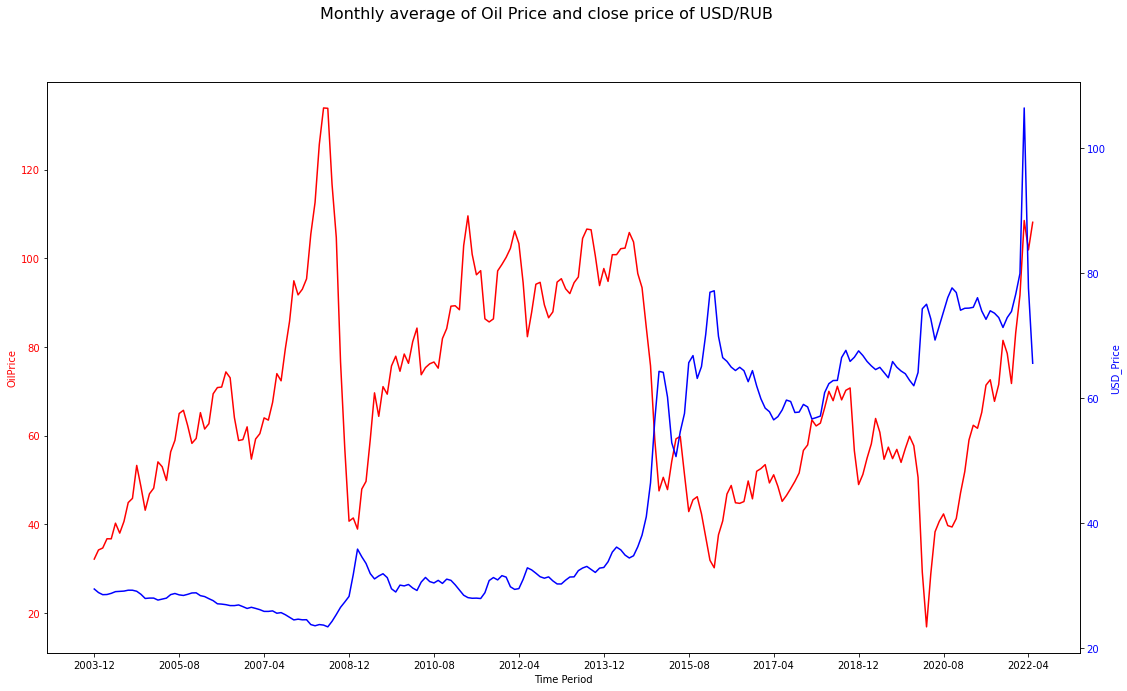

In [26]:
# Define Data
x = all_curr_wti['Calendar_date'].astype(str)
data_1 = all_curr_wti['OilPrice']
data_2 = all_curr_wti['USD_Price']
#creating an array with percentage change of oilprice from one month to another
data_3 = all_curr_wti['OilPrice'].pct_change()  

# Create Plot
fig, ax1 = plt.subplots() 
fig.set_size_inches(18.5, 10.5)
  
ax1.set_xlabel('Time Period') 
ax1.set_ylabel('OilPrice', color = 'red') 
ax1.plot(x, data_1, color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'red') 
  
# Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('USD_Price', color = 'blue') 
ax2.plot(x, data_2, color = 'blue') 
ax2.tick_params(axis ='y', labelcolor = 'blue') 
# Reduce xtick label
ax1.xaxis.set_major_locator(plt.MaxNLocator(15))
fig.suptitle("Monthly average of Oil Price and close price of USD/RUB",fontsize = 16)
# Show plot

plt.show()

In [27]:
all_curr_wti

,Calendar_date,USD_Price,USD_Open,USD_High,USD_Low,Change %_x,EUR_Price,EUR_Open,EUR_High,EUR_Low,Change %_y,OilPrice,Overnight_int_rate,Inflation_rate
0,2003-12,29.413304,29.428435,29.451174,29.381913,-0.073913,36.210087,36.133957,36.326087,35.993348,0.138261,32.157826,20.000000,1.10
1,2004-01,28.844485,28.873500,28.895258,28.819167,-0.116364,36.344273,36.386409,36.605682,36.130045,-0.150455,34.210758,16.727273,1.75
2,2004-02,28.506100,28.500100,28.544400,28.473200,-0.001500,36.018200,35.990750,36.256350,35.789250,0.010500,34.658333,14.000000,0.99
3,2004-03,28.532304,28.530609,28.556174,28.505739,-0.000870,34.994696,35.007391,35.230739,34.767000,-0.060870,36.741304,14.000000,0.75
4,2004-04,28.718864,28.693727,28.744727,28.672182,0.079091,34.456409,34.453045,34.634636,34.232364,-0.044091,36.723636,14.000000,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,2022-01,76.617710,76.487933,77.184152,75.935757,0.175714,86.711238,86.594429,87.404667,85.948476,0.142381,83.200317,9.500000,0.99
218,2022-02,79.942150,78.708405,81.262335,77.132105,1.726000,88.795900,87.858600,90.404350,87.041700,1.044500,91.673500,10.575000,1.17
219,2022-03,106.447391,105.951957,111.294535,101.504461,-0.884348,113.299435,115.651522,120.643522,108.037174,-0.589130,108.502609,21.000000,7.61
220,2022-04,77.603810,78.186667,78.893571,76.419238,-0.735238,86.671095,87.614952,89.549238,83.795476,-0.715238,101.877302,15.571429,1.56


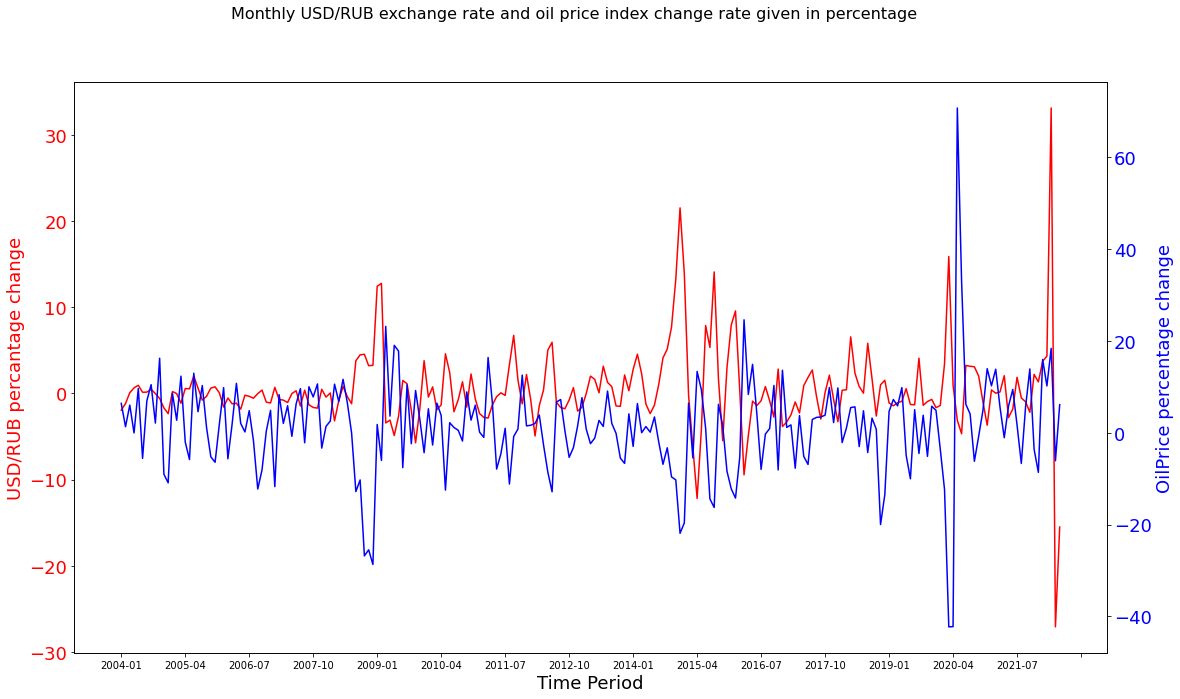

In [28]:
# Define Data
change = all_curr_wti.copy()
#adding the column with percentage change of USD/RUB from one month to another to the dataframe for visualization
change['USD_Price_PCT'] = change['USD_Price'].pct_change()*100

#adding the column with percentage change of oilrpice from one month to another to the main dataframe
change['OilPrice_PCT'] = change['OilPrice'].pct_change()*100

#dropna because the first na does not have the change 
change = change.dropna()

#array with percentage change of USD/RUB from one month to another to the dataframe for visualization
data_3 = change['USD_Price_PCT']

#array with percentage change of oilprice from one month to another to the dataframe for visualization
data_4 = change['OilPrice_PCT']

x = change['Calendar_date'].astype(str)

# Create Plot
fig, ax1 = plt.subplots() 
fig.set_size_inches(18.5, 10.5)

ax1.set_xlabel('Time Period',fontsize = 18) 
ax1.set_ylabel('USD/RUB percantage change', color = 'red',fontsize = 18) 
ax1.plot(x, data_3, color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'red',labelsize = 18) 
ax1.grid(False)
ax1.set_facecolor('xkcd:white')

# Adding Twin Axes
ax2 = ax1.twinx() 
ax2.set_ylabel('OilPrice percentage change', color = 'blue',fontsize = 18) 
ax2.plot(x, data_4, color = 'blue') 
ax2.tick_params(axis ='y', labelcolor = 'blue',labelsize = 18)
ax2.grid(False)
ax2.set_facecolor('xkcd:white')

# Reduce xtick label
ax1.xaxis.set_major_locator(plt.MaxNLocator(20))
fig.suptitle("Monthly USD/RUB exchange rate and oil price index change rate given in percentage", fontsize = 16)

# Show plot
plt.show()

In [29]:
all_curr_wti

,Calendar_date,USD_Price,USD_Open,USD_High,USD_Low,Change %_x,EUR_Price,EUR_Open,EUR_High,EUR_Low,Change %_y,OilPrice,Overnight_int_rate,Inflation_rate
0,2003-12,29.413304,29.428435,29.451174,29.381913,-0.073913,36.210087,36.133957,36.326087,35.993348,0.138261,32.157826,20.000000,1.10
1,2004-01,28.844485,28.873500,28.895258,28.819167,-0.116364,36.344273,36.386409,36.605682,36.130045,-0.150455,34.210758,16.727273,1.75
2,2004-02,28.506100,28.500100,28.544400,28.473200,-0.001500,36.018200,35.990750,36.256350,35.789250,0.010500,34.658333,14.000000,0.99
3,2004-03,28.532304,28.530609,28.556174,28.505739,-0.000870,34.994696,35.007391,35.230739,34.767000,-0.060870,36.741304,14.000000,0.75
4,2004-04,28.718864,28.693727,28.744727,28.672182,0.079091,34.456409,34.453045,34.634636,34.232364,-0.044091,36.723636,14.000000,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,2022-01,76.617710,76.487933,77.184152,75.935757,0.175714,86.711238,86.594429,87.404667,85.948476,0.142381,83.200317,9.500000,0.99
218,2022-02,79.942150,78.708405,81.262335,77.132105,1.726000,88.795900,87.858600,90.404350,87.041700,1.044500,91.673500,10.575000,1.17
219,2022-03,106.447391,105.951957,111.294535,101.504461,-0.884348,113.299435,115.651522,120.643522,108.037174,-0.589130,108.502609,21.000000,7.61
220,2022-04,77.603810,78.186667,78.893571,76.419238,-0.735238,86.671095,87.614952,89.549238,83.795476,-0.715238,101.877302,15.571429,1.56


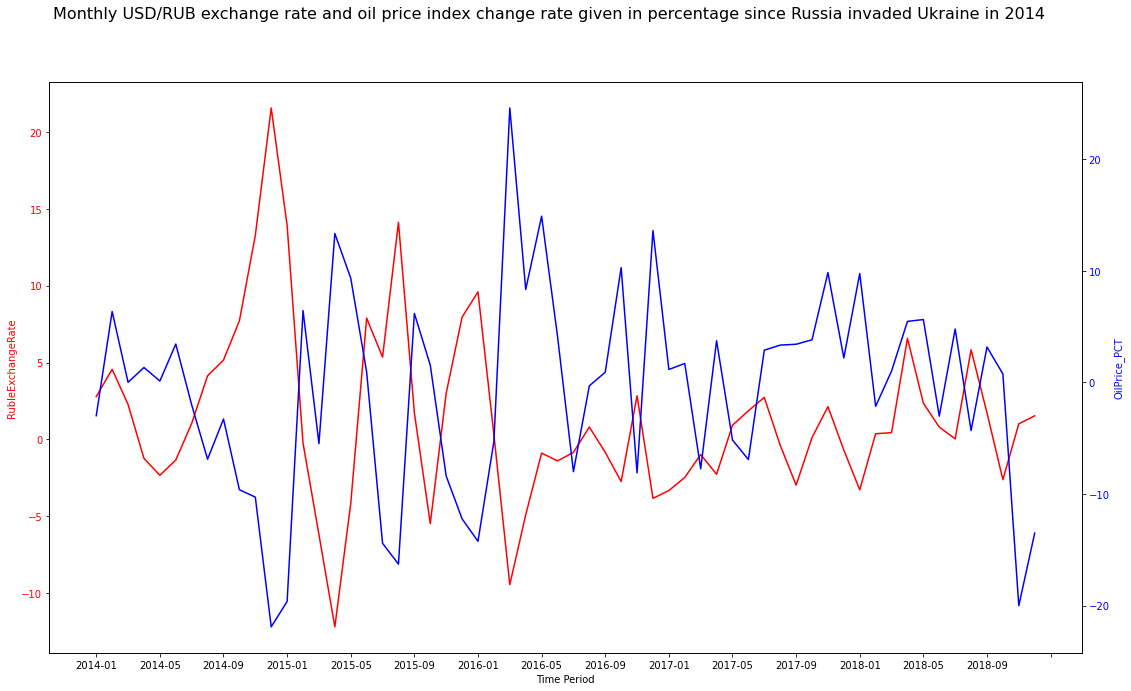

In [30]:
# Define Data to get a narrower time period 
data_3 = data_3.loc[121:180]
data_4 = data_4.loc[121:180]
x= x.iloc[120:180]

# Create Plot
fig, ax1 = plt.subplots() 
fig.set_size_inches(18.5, 10.5)
fig.suptitle("Monthly USD/RUB exchange rate and oil price index change rate given in percentage since Russia invaded Ukraine in 2014", fontsize = 16)

ax1.set_xlabel('Time Period') 
ax1.set_ylabel('RubleExchangeRate', color = 'red') 
ax1.plot(x, data_3, color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'red') 

# Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('OilPrice_PCT', color = 'blue') 
ax2.plot(x, data_4, color = 'blue') 
ax2.tick_params(axis ='y', labelcolor = 'blue')

# Reduce xtick label
ax1.xaxis.set_major_locator(plt.MaxNLocator(20))

# Show plot
plt.show()

In [31]:
all_curr_wti

,Calendar_date,USD_Price,USD_Open,USD_High,USD_Low,Change %_x,EUR_Price,EUR_Open,EUR_High,EUR_Low,Change %_y,OilPrice,Overnight_int_rate,Inflation_rate
0,2003-12,29.413304,29.428435,29.451174,29.381913,-0.073913,36.210087,36.133957,36.326087,35.993348,0.138261,32.157826,20.000000,1.10
1,2004-01,28.844485,28.873500,28.895258,28.819167,-0.116364,36.344273,36.386409,36.605682,36.130045,-0.150455,34.210758,16.727273,1.75
2,2004-02,28.506100,28.500100,28.544400,28.473200,-0.001500,36.018200,35.990750,36.256350,35.789250,0.010500,34.658333,14.000000,0.99
3,2004-03,28.532304,28.530609,28.556174,28.505739,-0.000870,34.994696,35.007391,35.230739,34.767000,-0.060870,36.741304,14.000000,0.75
4,2004-04,28.718864,28.693727,28.744727,28.672182,0.079091,34.456409,34.453045,34.634636,34.232364,-0.044091,36.723636,14.000000,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,2022-01,76.617710,76.487933,77.184152,75.935757,0.175714,86.711238,86.594429,87.404667,85.948476,0.142381,83.200317,9.500000,0.99
218,2022-02,79.942150,78.708405,81.262335,77.132105,1.726000,88.795900,87.858600,90.404350,87.041700,1.044500,91.673500,10.575000,1.17
219,2022-03,106.447391,105.951957,111.294535,101.504461,-0.884348,113.299435,115.651522,120.643522,108.037174,-0.589130,108.502609,21.000000,7.61
220,2022-04,77.603810,78.186667,78.893571,76.419238,-0.735238,86.671095,87.614952,89.549238,83.795476,-0.715238,101.877302,15.571429,1.56


# Model Building

# Linear Regression Model

In [32]:
# LinearRegression is a machine learning library for linear regression
from sklearn.linear_model import LinearRegression


# matplotlib and seaborn are used for plotting graphs
%matplotlib inline
plt.style.use('seaborn-darkgrid')


Trial N1 

In [33]:
all_curr_wti

,Calendar_date,USD_Price,USD_Open,USD_High,USD_Low,Change %_x,EUR_Price,EUR_Open,EUR_High,EUR_Low,Change %_y,OilPrice,Overnight_int_rate,Inflation_rate
0,2003-12,29.413304,29.428435,29.451174,29.381913,-0.073913,36.210087,36.133957,36.326087,35.993348,0.138261,32.157826,20.000000,1.10
1,2004-01,28.844485,28.873500,28.895258,28.819167,-0.116364,36.344273,36.386409,36.605682,36.130045,-0.150455,34.210758,16.727273,1.75
2,2004-02,28.506100,28.500100,28.544400,28.473200,-0.001500,36.018200,35.990750,36.256350,35.789250,0.010500,34.658333,14.000000,0.99
3,2004-03,28.532304,28.530609,28.556174,28.505739,-0.000870,34.994696,35.007391,35.230739,34.767000,-0.060870,36.741304,14.000000,0.75
4,2004-04,28.718864,28.693727,28.744727,28.672182,0.079091,34.456409,34.453045,34.634636,34.232364,-0.044091,36.723636,14.000000,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,2022-01,76.617710,76.487933,77.184152,75.935757,0.175714,86.711238,86.594429,87.404667,85.948476,0.142381,83.200317,9.500000,0.99
218,2022-02,79.942150,78.708405,81.262335,77.132105,1.726000,88.795900,87.858600,90.404350,87.041700,1.044500,91.673500,10.575000,1.17
219,2022-03,106.447391,105.951957,111.294535,101.504461,-0.884348,113.299435,115.651522,120.643522,108.037174,-0.589130,108.502609,21.000000,7.61
220,2022-04,77.603810,78.186667,78.893571,76.419238,-0.735238,86.671095,87.614952,89.549238,83.795476,-0.715238,101.877302,15.571429,1.56


In [44]:
# Define explanatory variable
all_curr_wti['next_month_price'] = all_curr_wti['USD_Price'].shift(-1)
all_curr_wti = all_curr_wti.dropna()
#all_curr_wti = WTIRUB.dropna()
X = all_curr_wti[['USD_Price','USD_Open','USD_High','USD_Low','OilPrice','Overnight_int_rate','Inflation_rate']]
# Define dependent variable
y = all_curr_wti['next_month_price']

# Split the data into train and test dataset
t = .77
t = int(t*len(all_curr_wti))

# Train dataset
X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]

# Create a linear regression model
linear = LinearRegression().fit(X_train, y_train)

# R square
r2_score = linear.score(X_train, y_train)*100
float("{0:.10f}".format(r2_score))
print ("Training accuracy:",r2_score)

# R square
r2_score = linear.score(X_test, y_test)*100
float("{0:.10f}".format(r2_score))
print ("Testing accuracy:",r2_score)

Training accuracy: 99.04474512850527
Testing accuracy: 88.38550964315323


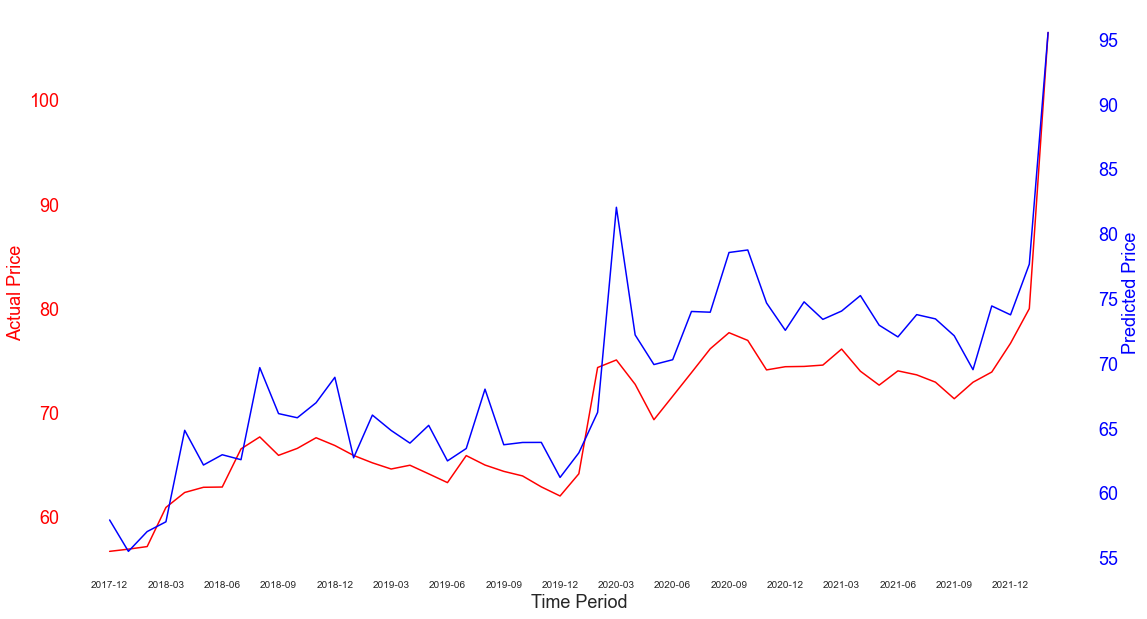

In [45]:
# Predicting RUB against USD Price
predicted_price = linear.predict(X_test)
#predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['USD_Price'])


# Define Data to get a narrower time period 
x= all_curr_wti['Calendar_date'][t:].astype(str)

# Create Plot
fig, ax1 = plt.subplots() 
fig.set_size_inches(18.5, 10.5)

ax1.set_xlabel('Time Period',fontsize = 18) 
ax1.set_ylabel('Actual Price', color = 'red',fontsize = 18) 
ax1.plot(x, y_test, color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'red',labelsize = 18) 
ax1.grid(False)
ax1.set_facecolor('xkcd:white')

# Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('Predicted Price', color = 'blue',fontsize = 18) 
ax2.plot(x, predicted_price, color = 'blue') 
ax2.tick_params(axis ='y', labelcolor = 'blue',labelsize = 18)
ax2.grid(False)
ax2.set_facecolor('xkcd:white')
# Reduce xtick label
ax1.xaxis.set_major_locator(plt.MaxNLocator(20))
# Show plot
plt.show()

In [46]:
# get importance
importance = linear.coef_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.3f' % (i,v))

Feature: 0, Score: 12.416
Feature: 1, Score: -15.731
Feature: 2, Score: 2.288
Feature: 3, Score: 2.007
Feature: 4, Score: -0.004
Feature: 5, Score: -0.075
Feature: 6, Score: -0.489


In [47]:
#Prediction for the May outcome of USD/RUB exchange rate
may_x = [[65.568854,66.375938,67.029340,64.674931,108.102500,15.000000,0.15]]
print('June prediction for USD/RUB exchange rate: %.3f'% linear.predict(may_x))
stdev = np.sqrt(sum((linear.predict(X_train) - y_train)**2) / (len(y_train) - 2))
print('Confidence interval %.3f \
- %.3f' % (linear.predict(may_x) - 1.96*stdev, linear.predict(may_x) + 1.96*stdev))

June prediction for USD/RUB exchange rate: 53.590
Confidence interval 50.883 - 56.296


In [48]:
print('mean_absolute_percentage_error: %.3f'%(mean_absolute_percentage_error(y_test, predicted_price)*100))

mean_absolute_percentage_error: 2.393


In [49]:
# Define explanatory variable
all_curr_wti['next_month_price'] = all_curr_wti['USD_Price'].shift(-1)
all_curr_wti = all_curr_wti.dropna()
#all_curr_wti = WTIRUB.dropna()
X = all_curr_wti[['USD_Price','USD_Open','USD_High','USD_Low','EUR_Price','EUR_Price','EUR_High','EUR_Low','OilPrice','Overnight_int_rate','Inflation_rate']]
# Define dependent variable
y = all_curr_wti['next_month_price']

# Split the data into train and test dataset
t = .77
t = int(t*len(all_curr_wti))

# Train dataset
X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]

# Create a linear regression model
linear = LinearRegression().fit(X_train, y_train)

# R square
r2_score = linear.score(X_train, y_train)*100
float("{0:.10f}".format(r2_score))
print ("Training accuracy:",r2_score)

# R square
r2_score = linear.score(X_test, y_test)*100
float("{0:.10f}".format(r2_score))
print ("Testing accuracy:",r2_score)

Training accuracy: 99.05377833209886
Testing accuracy: 87.38598930365299


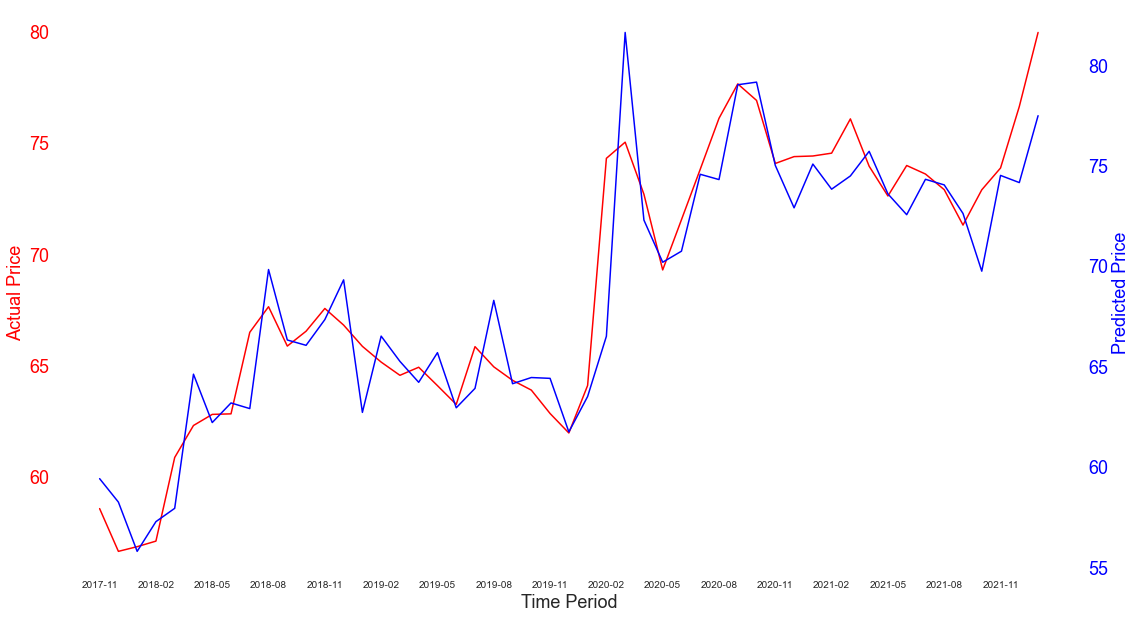

In [50]:
# Predicting RUB against USD Price
predicted_price = linear.predict(X_test)
#predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['USD_Price'])


# Define Data to get a narrower time period 
x= all_curr_wti['Calendar_date'][t:].astype(str)

# Create Plot
fig, ax1 = plt.subplots() 
fig.set_size_inches(18.5, 10.5)

ax1.set_xlabel('Time Period',fontsize = 18) 
ax1.set_ylabel('Actual Price', color = 'red',fontsize = 18) 
ax1.plot(x, y_test, color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'red',labelsize = 18) 
ax1.grid(False)
ax1.set_facecolor('xkcd:white')

# Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('Predicted Price', color = 'blue',fontsize = 18) 
ax2.plot(x, predicted_price, color = 'blue') 
ax2.tick_params(axis ='y', labelcolor = 'blue',labelsize = 18)
ax2.grid(False)
ax2.set_facecolor('xkcd:white')
# Reduce xtick label
ax1.xaxis.set_major_locator(plt.MaxNLocator(20))
# Show plot
plt.show()

In [51]:
# get importance
importance = linear.coef_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.3f' % (i,v))
# plot feature importance

Feature: 0, Score: 12.745
Feature: 1, Score: -15.290
Feature: 2, Score: 2.001
Feature: 3, Score: 1.534
Feature: 4, Score: 0.719
Feature: 5, Score: 0.719
Feature: 6, Score: -1.502
Feature: 7, Score: 0.067
Feature: 8, Score: -0.008
Feature: 9, Score: -0.108
Feature: 10, Score: -0.496


In [52]:
#Prediction for the May outcome of USD/RUB exchange rate
may_x = [[65.568854,66.375938,67.029340,64.674931,69.304250,70.280875,71.510063,67.091437,108.102500,15.000000,0.15]]
print('June prediction for USD/RUB exchange rate: %.3f'% linear.predict(may_x))
stdev = np.sqrt(sum((linear.predict(X_train) - y_train)**2) / (len(y_train) - 2))
print('Confidence interval %.3f \
- %.3f' % (linear.predict(may_x) - 1.96*stdev, linear.predict(may_x) + 1.96*stdev))

June prediction for USD/RUB exchange rate: 51.579
Confidence interval 48.897 - 54.261


In [53]:
print('mean_absolute_percentage_error: %.3f'%(mean_absolute_percentage_error(y_test, predicted_price)*100))

mean_absolute_percentage_error: 2.250


In [54]:
# Define explanatory variable
all_curr_wti['next_month_price'] = all_curr_wti['USD_Price'].shift(-1)
all_curr_wti = all_curr_wti.dropna()
#all_curr_wti = WTIRUB.dropna()
X = all_curr_wti[['USD_Price','USD_Open','USD_High','USD_Low','OilPrice']]
# Define dependent variable
y = all_curr_wti['next_month_price']

# Split the data into train and test dataset
t = .77
t = int(t*len(all_curr_wti))

# Train dataset
X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]

# Create a linear regression model
linear = LinearRegression().fit(X_train, y_train)

# R square
r2_score = linear.score(X_train, y_train)*100
float("{0:.10f}".format(r2_score))
print ("Training accuracy:",r2_score)

# R square
r2_score = linear.score(X_test, y_test)*100
float("{0:.10f}".format(r2_score))
print ("Testing accuracy:",r2_score)

Training accuracy: 98.98763455067535
Testing accuracy: 86.89561451228916


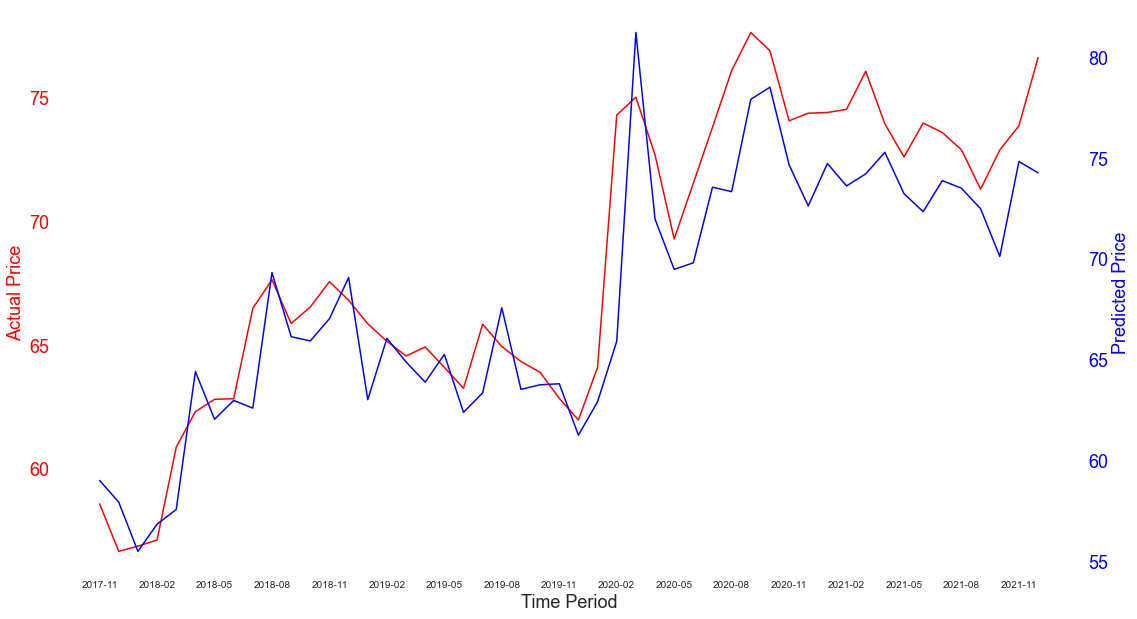

In [55]:
# Predicting RUB against USD Price
predicted_price = linear.predict(X_test)
#predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['USD_Price'])


# Define Data to get a narrower time period 
x= all_curr_wti['Calendar_date'][t:].astype(str)

# Create Plot
fig, ax1 = plt.subplots() 
fig.set_size_inches(18.5, 10.5)

ax1.set_xlabel('Time Period',fontsize = 18) 
ax1.set_ylabel('Actual Price', color = 'red',fontsize = 18) 
ax1.plot(x, y_test, color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'red',labelsize = 18) 
ax1.grid(False)
ax1.set_facecolor('xkcd:white')

# Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('Predicted Price', color = 'blue',fontsize = 18) 
ax2.plot(x, predicted_price, color = 'blue') 
ax2.tick_params(axis ='y', labelcolor = 'blue',labelsize = 18)
ax2.grid(False)
ax2.set_facecolor('xkcd:white')
# Reduce xtick label
ax1.xaxis.set_major_locator(plt.MaxNLocator(20))
# Show plot
plt.show()


In [56]:
# get importance
importance = linear.coef_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.3f' % (i,v))
# plot feature importance

Feature: 0, Score: 13.300
Feature: 1, Score: -14.385
Feature: 2, Score: 0.857
Feature: 3, Score: 1.226
Feature: 4, Score: 0.005


In [57]:
#Prediction for the May outcome of USD/RUB exchange rate
may_x = [[65.568854,66.375938,67.029340,64.674931,108.102500]]
print('June prediction for USD/RUB exchange rate: %.3f'% linear.predict(may_x))
stdev = np.sqrt(sum((linear.predict(X_train) - y_train)**2) / (len(y_train) - 2))
print('Confidence interval %.3f \
- %.3f' % (linear.predict(may_x) - 1.96*stdev, linear.predict(may_x) + 1.96*stdev))

June prediction for USD/RUB exchange rate: 54.307
Confidence interval 51.533 - 57.082


In [58]:
print('mean_absolute_percentage_error: %.3f'%(mean_absolute_percentage_error(y_test, predicted_price)*100))

mean_absolute_percentage_error: 2.155


# Conclusion: 
Building the model by dropping different features does not give conlusive results about the the most important and least imporant features. 
However, it was observed that the combination of either open and high, or low and close work better that any other combination of two of any of these features.
It was decided to keep the model with four features as it yiledls the highest training and testing accuracy.

# Deep learning model

In [99]:
#importing neccessary libraries
import pandas as pd
import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [103]:
X = all_curr_wti[['USD_Price','USD_Open','USD_High','USD_Low','OilPrice']]
# Define dependent variable
y = all_curr_wti['next_month_price']

# Split the data into train and test dataset
t = .77
t = int(t*len(all_curr_wti))

# Train dataset
X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]

In [104]:
model = Sequential()

# Define model
model = Sequential()
model.add(Dense(500, input_dim=5, activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(1))

model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_absolute_percentage_error"])
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
6/6 [==============================] - 0s 2ms/step - loss: 1221.9611 - mean_absolute_percentage_error: 87.4615
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 345.7094 - mean_absolute_percentage_error: 38.0124
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 134.1643 - mean_absolute_percentage_error: 31.1726
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 102.3642 - mean_absolute_percentage_error: 27.8764
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 31.9057 - mean_absolute_percentage_error: 11.0453
Epoch 6/100
6/6 [==============================] - 0s 2ms/step - loss: 27.1314 - mean_absolute_percentage_error: 11.3800
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 10.3805 - mean_absolute_percentage_error: 5.5181
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 11.5058 - mean_absolute_percentage_error: 5.4964
Epoch 9/100
6/6 [============

In [105]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss: %.3f' % score[0])
print('mean_absolute_percentage_error:%.3f' %score[1])
may_x = [[65.568854,66.375938,67.029340,64.674931,108.102500]]
predictions = model.predict(may_x)
print('June prediction for USD/RUB exchange rate: %.3f'% predictions)

y_testset = y_train.to_frame()
testdf = pd.DataFrame(y_testset)
testdf['pred_price'] = model.predict(X_train) 
testdf.astype(float)
stdev = np.sqrt(sum((testdf['pred_price'] - testdf['next_month_price'])**2) / (len(testdf['next_month_price']) - 2))
print('Confidence interval %.3f \
- %.3f' % (model.predict(may_x) - 1.96*stdev, model.predict(may_x) + 1.96*stdev))

Test loss: 4.796
mean_absolute_percentage_error:2.440
June prediction for USD/RUB exchange rate: 68.251
Confidence interval 64.469 - 72.033


In [106]:
X = all_curr_wti[['USD_Price','USD_Open','USD_High','USD_Low','OilPrice','Overnight_int_rate','Inflation_rate']]
# Define dependent variable
y = all_curr_wti['next_month_price']

# Split the data into train and test dataset
t = .77
t = int(t*len(all_curr_wti))

# Train dataset
X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]

In [107]:
model = Sequential()

# Define model
model = Sequential()
model.add(Dense(500, input_dim = 7, activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(1))

model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_absolute_percentage_error"])
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
6/6 [==============================] - 1s 6ms/step - loss: 843.9719 - mean_absolute_percentage_error: 59.1196
Epoch 2/100
6/6 [==============================] - 0s 12ms/step - loss: 149.4047 - mean_absolute_percentage_error: 33.2442
Epoch 3/100
6/6 [==============================] - 0s 6ms/step - loss: 61.3367 - mean_absolute_percentage_error: 20.4889
Epoch 4/100
6/6 [==============================] - 0s 5ms/step - loss: 27.7295 - mean_absolute_percentage_error: 10.2979
Epoch 5/100
6/6 [==============================] - 0s 4ms/step - loss: 9.1490 - mean_absolute_percentage_error: 5.6861
Epoch 6/100
6/6 [==============================] - 0s 5ms/step - loss: 8.6987 - mean_absolute_percentage_error: 4.6385
Epoch 7/100
6/6 [==============================] - 0s 4ms/step - loss: 7.1654 - mean_absolute_percentage_error: 5.3788
Epoch 8/100
6/6 [==============================] - 0s 5ms/step - loss: 5.0654 - mean_absolute_percentage_error: 3.6782
Epoch 9/100
6/6 [====================

In [108]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss: %.3f' % score[0])
print('mean_absolute_percentage_error:%.3f' %score[1])
may_x = [[65.568854,66.375938,67.029340,64.674931,108.102500,15.000000,0.15]]
predictions = model.predict(may_x)
print('June prediction for USD/RUB exchange rate: %.3f'% predictions)

y_testset = y_train.to_frame()
testdf = pd.DataFrame(y_testset)
testdf['pred_price'] = model.predict(X_train) 
testdf.astype(float)
stdev = np.sqrt(sum((testdf['pred_price'] - testdf['next_month_price'])**2) / (len(testdf['next_month_price']) - 2))
print('Confidence interval %.3f \
- %.3f' % (model.predict(may_x) - 1.96*stdev, model.predict(may_x) + 1.96*stdev))

Test loss: 7.812
mean_absolute_percentage_error:3.458
June prediction for USD/RUB exchange rate: 71.784
Confidence interval 67.907 - 75.661


In [109]:
X = all_curr_wti[['USD_Price','USD_Open','USD_High','USD_Low','EUR_Price','EUR_Price','EUR_High','EUR_Low','OilPrice','Overnight_int_rate','Inflation_rate']]
# Define dependent variable
y = all_curr_wti['next_month_price']

# Split the data into train and test dataset
t = .77
t = int(t*len(all_curr_wti))

# Train dataset
X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]

In [110]:
model = Sequential()

# Define model
model = Sequential()
model.add(Dense(500, input_dim=11, activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(1))

model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_absolute_percentage_error"])
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
6/6 [==============================] - 1s 2ms/step - loss: 711.6400 - mean_absolute_percentage_error: 56.7743
Epoch 2/100
6/6 [==============================] - 0s 4ms/step - loss: 150.4342 - mean_absolute_percentage_error: 36.5460
Epoch 3/100
6/6 [==============================] - 0s 5ms/step - loss: 28.2121 - mean_absolute_percentage_error: 11.0566
Epoch 4/100
6/6 [==============================] - 0s 6ms/step - loss: 40.9913 - mean_absolute_percentage_error: 12.0213
Epoch 5/100
6/6 [==============================] - 0s 5ms/step - loss: 9.1590 - mean_absolute_percentage_error: 6.3099
Epoch 6/100
6/6 [==============================] - 0s 4ms/step - loss: 6.9608 - mean_absolute_percentage_error: 4.9263
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 6.5994 - mean_absolute_percentage_error: 4.5668
Epoch 8/100
6/6 [==============================] - 0s 5ms/step - loss: 6.1662 - mean_absolute_percentage_error: 4.5406
Epoch 9/100
6/6 [=====================

In [111]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss: %.3f' % score[0])
print('mean_absolute_percentage_error:%.3f' %score[1])
may_x = [[65.568854,66.375938,67.029340,64.674931,69.304250,70.280875,71.510063,67.091437,108.102500,15.000000,0.15]]
predictions = model.predict(may_x)
print('June prediction for USD/RUB exchange rate: %.3f'% predictions)

y_testset = y_train.to_frame()
testdf = pd.DataFrame(y_testset)
testdf['pred_price'] = model.predict(X_train) 
testdf.astype(float)
stdev = np.sqrt(sum((testdf['pred_price'] - testdf['next_month_price'])**2) / (len(testdf['next_month_price']) - 2))
print('Confidence interval %.3f \
- %.3f' % (model.predict(may_x) - 1.96*stdev, model.predict(may_x) + 1.96*stdev))


Test loss: 17.069
mean_absolute_percentage_error:5.489
June prediction for USD/RUB exchange rate: 68.326
Confidence interval 64.155 - 72.497


# Conlusion: Oil Price signficantly contributes to the USD/RUB exchange rate predictions. However, elimiating Oil Price from features and relying on other inner economic indicators consitstently resulted in higher value of USD/RUB exchange rate in both linear regression and Keras models with maximum nunber of parameters analysed in this work.  